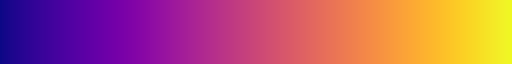

In [3]:
import tensorflow
import crepe

import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import interpolate
import time
from matplotlib import cm
cm.plasma

The following cell is an algorithm I got from stackoverflow and modified slightly. It basically identifies peaks based on the heuristic in the slides.

In [3]:
class real_time_peak_detection():
    def __init__(self, array, lag, threshold, influence):
        """ 
        these are the params for detection
        lag is the time interval that it 'scans' over
        threshold is how many standard deviations away a point has to be before it's considered a 'peak'
        influence is a scaling factor to reduce how much the 'peak' values affect the moving average. If you set it to 0 then the moving average will be static during time ranges where a peak is detected.

        signals is the input data. I honestly think it's kinda inefficient how this is set up, but I think it's so that it can handle real-time data. Didn't feel like making a new method just for quick testing so I left it as is. The function will only tekll you whether the next point is a peak or not.
        # Matthew   
        # Input: 
        # - array <list> (1xN): signal
        # - lag <int>: time interval
        # - threshold <float>: # standard deviations deviation
        # - influence <float>: alpha weight given to current value in exponential smoothing. 
        # Output: 
        # > signals[i] <int> (1,): annotation on new input data (1 = +ve peak -1 = -ve peak) 
        # > influence is alpha weight given to current value in exponential smoothing.
        # > self.avgFilter[i] <float>: rolling mean
        # > self.stdFilter[i] <float>: rolling std deviation         
        """
        
        self.y = list(array)
        self.length = len(self.y)
        self.lag = lag 
        self.threshold = threshold
        self.influence = influence
        """
        so the next few lines here is to set up the initial values (because it can't start finding a 'moving average' until it has enough values to average over)
        """
        self.signals = [0] * len(self.y)
        self.filteredY = np.array(self.y).tolist()
        self.avgFilter = [0] * len(self.y)
        self.stdFilter = [0] * len(self.y)
        self.avgFilter[self.lag - 1] = np.mean(self.y[0:self.lag]).tolist()
        self.stdFilter[self.lag - 1] = np.std(self.y[0:self.lag]).tolist()

    def thresholding_algo(self, new_value):
        """
        this is to handle the next input
        """
        self.y.append(new_value)
        i = len(self.y) - 1
        self.length = len(self.y)
        if i < self.lag: # as mentioned earlier - can't start finding a 'moving average' until there's enough values
            return 0
        elif i == self.lag: # when there's enough values then it starts to find moving average
            self.signals = [0] * len(self.y)
            self.filteredY = np.array(self.y).tolist()
            self.avgFilter = [0] * len(self.y)
            self.stdFilter = [0] * len(self.y)
            self.avgFilter[self.lag] = np.mean(self.y[0:self.lag]).tolist()
            self.stdFilter[self.lag] = np.std(self.y[0:self.lag]).tolist()
            return 0

        self.signals += [0]
        self.filteredY += [0]
        self.avgFilter += [0]
        self.stdFilter += [0]

        if abs(self.y[i] - self.avgFilter[i - 1]) > (self.threshold * self.stdFilter[i - 1]): # then check if the value exceeds the threshold for peak detection, if it does, then it registers it as a 'peak range' and returns back 

            if self.y[i] > self.avgFilter[i - 1]:
                self.signals[i] = 1
            else:
                self.signals[i] = -1

            self.filteredY[i] = self.influence * self.y[i] + \
                (1 - self.influence) * self.filteredY[i - 1]
            self.avgFilter[i] = np.mean(self.filteredY[(i - self.lag):i])
            self.stdFilter[i] = np.std(self.filteredY[(i - self.lag):i])
        else:
            self.signals[i] = 0
            self.filteredY[i] = self.y[i]
            self.avgFilter[i] = np.mean(self.filteredY[(i - self.lag):i])
            self.stdFilter[i] = np.std(self.filteredY[(i - self.lag):i])

        return self.signals[i], self.avgFilter[i], self.stdFilter[i]

The following cell makes use of the above method.

It takes in a y-x graph ('frame data', should be a list of lists) and some parameters for calibrating the detection method. It will return the ranges of x for which y is a peak.

In our case, we use a graph of amplitude against frequency, so it should return the ranges of frequencies for which amplitude has peaks.

In [14]:
def get_peak_ranges(frame_data, window = 10, threshold = 0.7, influence = 0.5, freq_list = None, show=False, title = None):
    """
    # Input:
    # - frame_data <[float]> 1 x Nfreq:  frequency bins output from 1 time frame.   
    # - window <int>: window bins (in freq)
    # - threshold <float>: alpha factor smoothing
    # - freq_list [float] 1xNfreq: frequency axis 
    # matthew comments: i think 2d non-maximal suppression is better.. 
    # Output: 
    # - peak <[int]> Ntime x Nfreq: +-1 for presence of peak in x-direction (positive or negative), 0 otherwise 
    """
    # input is the spectrum for one time-frame
    # output is the set of coordinates
    peak = []
    moving_averages = []
    st_devs = []
    for i in range(int(window/2)):
        peak.append(0)
        moving_averages.append(frame_data[i])
        st_devs.append(0)

    for i in range(len(frame_data)-(window)):
        current_window = frame_data[i:i+window]
        
        if window %2 == 0: #even
            next_value = (current_window[int(window/2)] + current_window[int((window/2)-1)])/2
        else: #odd
            next_value = current_window[int((window-1)/2)] 
        
        # simulate real time algo. 
        moving_average_calculator = real_time_peak_detection(current_window, lag = window, threshold = threshold, influence = influence) # this tells me whether the next point is a peak
        moving_average_calculator.thresholding_algo(next_value)
        peak_detect, moving_average, st_dev = moving_average_calculator.thresholding_algo(next_value)
        # the next 3 lines are just to set up 3 lists to correspond to: is this timeframe a peak or not, what is the moving average for the timeframe, what is the stdev for the timeframe
        # actually I don't need to collect the list of moving average and stdev. The real_time_peak_detection method already makes use of it internally. But I wanted this data to plot the graph later.
        peak.append(peak_detect)
        moving_averages.append(moving_average)
        st_devs.append(st_dev*threshold)

    if show:
        fig, ax = plt.subplots(figsize=[15,5])
        ax.plot(freq_list[:len(moving_averages)], moving_averages, color = 'red')
        ax.plot(freq_list[:len(moving_averages)], [x+y for x,y in zip(moving_averages,st_devs)], color = 'red', alpha=0.5) # this is the upper range (above this range is a 'peak')
        ax.plot(freq_list[:len(moving_averages)], [x-y for x,y in zip(moving_averages,st_devs)], color = 'red', alpha=0.5) # lower range. This would be considered a trough (anti-peak) but in this case we don't care.

        ax.plot(freq_list, frame_data, color='black')
        
        if title != None:
            ax.set_title(title)

        #ticks = np.arange(4,15)
        #ax.set_xticks(ticks)
        #ax.set_xticklabels(2**ticks)
        ax.set_xlim([0,2000])
        plt.show()

    return peak, moving_averages, st_devs

Then using the method in the previous cell, we scan each range from that function to find the highest point in that range. We assume each 'peak range' has just one peak.

In [17]:
def find_peaks(peak, frame_data, freq_list):
    """Track peak location over time. 
    Args:
        peak <[int]> Ntime x 1: Peak algo run in x-direction
        frame_data ([[float]]): Ntime x Nfreq STFT output
        freq_list ([float]): frequency axis

    Returns:
        peak_coordinates <idx in freq axis> (2 x Ntime): [magnitude, freq value] per time frame defining coordinates where peaks were found. (if no new peaks found, then 1-hold the previously found peak for the time frame.)
    """
    peak_coordinates = []
    peaks = []
    freqs = []
    for i in range(len(peak)):
        if peak[i] != 1:
            if len(peaks) != 0:
                peak_coordinates.append([max(peaks),freqs[peaks.index(max(peaks))]])  # this fails when peaks is empty so check for it above
            peaks = []
            freqs = []
        elif peak[i] == 1:
            peaks.append(frame_data[i])
            freqs.append(freq_list[i])
    if len(peak_coordinates) == 0:
        return None
    else:
        return peak_coordinates

The next cell brings those functions together, and I also added a bunch of other attempts to improve the fitting (but it still doesn't work well).

It also applies it three times at different granularities (start with a coarse sweep then get finer).

I also tried some methods to reduce the search range but those seemed to cause problems with missing out minima, so right now it's just a brute force grid search.

In [19]:
# define it as a function

def sample_one_f0(test_freq, test_peaks, recent_average, scaled_search_range):
    """try out a hypothesis, check its loss against measured peaks.
    assumption: If harmonic is correct, will match at least one of peaks. (minimum loss) 
    
    Args:
        test_freq (float): guess harmonic f0 
        test_peaks ([[float, float]]) 2xNtime: frequency peaks detected over time: [magnitude of response, frequency value] for each time frame 
        recent_average (): Not recommmended to use. ignore.
        scaled_search_range (_type_): _description_

    Returns:
        _type_: _description_
    """
    plot_coordinates = []
    test_peaks_temp = test_peaks.copy()
    debugging_outputs = []

    for coefficient in range(1,11): # 1 to 10 is arbitrary. I just randomly test the first 10 harmonics of the proposed f0 to try and see how well it fits. Anyway, you should never have to test more than 10.
        if len(test_peaks_temp) == 0: # to catch cases where no peaks are detected and avoid the function just crashing.
            break
        losses = [(coefficient*test_freq-peak[1])**2 for peak in test_peaks_temp] # basically MSE loss between (harmonic of proposed f0) - (nearest peak found)
        min_loss = min(losses)
        nearest_peak = test_peaks_temp[losses.index(min_loss)]
        test_peaks_temp.remove(nearest_peak)

        # in the next few lines you can see I tried adding other losses to my loss function. It needs finetuning.
        height_loss = (100-nearest_peak[0])**2
        freq_loss = (nearest_peak[1])**2
        plot_coordinates.append(((height_loss)/100)*min_loss)#/freq_loss) # we should scale it by how tall the peak is, and have lower frequency peaks be more important
        debugging_outputs.append([min_loss,height_loss,freq_loss])
        

    # add something to consider peaks that have not been accounted for. 
    # For example, maybe I propose that f0 = 200, and I find that 200, 400, 600... all fit nicely, so it seems like it's the correct answer
    # but if the real ans is f0 = 100, then that means I will not have accounted for 100, 300, 500, 700, so I need some loss to penalise missing those out.
    # The most important freqs to account for are lower frequencies, so this loss should increase with increasing magnitude and decrease with increasing frequency. Higher loss is a bad thing.
    leftover_loss = sum([(100-x[0])/x[1] for x in test_peaks_temp])+1  ## loss penalizes directly magnitude (for missed responses) and inversely penalizes freq value.
    
    # the point of this 'recent_average' thing is that I wanted to try to make use of previous context
    # for example, if the last few timeframes had f0 = 100, 105, 110, 115, 120, then we can expect this new frame to have f0 somewhere in the vicinity of 125.
    # howver this turned out to not work very well, because firstly the pitch can change surprisingly rapidly, and secondly, if there was an error, then it will propagate onwards.
    # we should just remove this bit unless we have some better way to implement.    
    if recent_average == None:
        returned_loss = sum([x for x in plot_coordinates])*leftover_loss
    else:
        returned_loss = (sum([x for x in plot_coordinates])/((recent_average - test_freq+0.01)/scaled_search_range)**2)*leftover_loss #scaled by distance to recent average

    debugging_returns = [returned_loss, sum([x[0] for x in debugging_outputs]), sum([x[1] for x in debugging_outputs]), sum([x[2] for x in debugging_outputs]), leftover_loss] # this is just for my own debugging purposes...
    return returned_loss, debugging_returns

def estimate_f0(peak_coordinates = [], peak=[], freq_list = [], lower_freq = 10, upper_freq = 310, test_interval = 10, recent_average = None, scaled_search_range = None):
    """
    this is the function to put everything together and find f0. The previous function 'sample_one_f0' was meant to find the loss of a single proposed f0. 
    Now this function will iterate 'sample_one_f0' over all possible f0 candidates to find the one with the best fit.
    Inputs: 
    - peak_coordinates <[2xNtime]>: [magnitude, freq value] for each time instant 
    - peak <[int]>: list of flags 1/-1/0 (on presence of peak in each time instant)
    - freq_list <[float]> [1xNtime]: frequency axis
    """
    
    # first set a range to test within
    # human voice f0 would always be in this range
    lower_freq = max(30,lower_freq)
    upper_freq = min(310,upper_freq)
    test_freqs = np.arange(lower_freq, upper_freq, test_interval) # this is a grid method
    #test_peaks = [x for x in peak_coordinates if x[1]<upper_freq]
    #test_peaks = [x for x in test_peaks if x[1]>lower_freq]
    test_peaks = [x for x in peak_coordinates if x[1]>lower_freq] # test_peaks is the actual data obtained from the peak detection algorithm applied to the
                                                                  # stft output. So we basically iterate over all test_freqs, for each test_freq we iterate over
                                                                  # the 1-10 harmonics in sample_one_f0 and compare these harmonics to the peak coordinates to find the best fit.

    """
    the next segment is to remove the peaks that might be irrelevant
    """
    highest_peak_value = max([x[0] for x in test_peaks])
    test_peaks = [x for x in test_peaks if (100+x[0]) > 0.8*(100+highest_peak_value)] # we don't need all the peaks

    # peak is the list of frequencies that are in the brightest part of the spectrm
    # we limit peak testing to only these freqs, assume f0 is always present for human voice
    allowed_freqs = []
    allowed_freq_ranges = []
    start_freq = 0
    end_freq = 0
    open_interval = False
    peak_table = pd.DataFrame([np.arange(len(peak)),peak,freq_list], index=['i','peak','freq']).transpose()
    peak_table = peak_table.loc[peak_table['peak'] == 1]

    for freq_index in range(len(peak)):
        peak_flag = peak[freq_index]
        if (peak_flag == 1):
            allowed_freqs.append(freq_list[freq_index])
            if (open_interval == False):
                start_freq = freq_list[freq_index]
                open_interval = True
        if (open_interval == True) and (peak_flag != 1):
            end_freq = freq_list[freq_index]
            allowed_freq_ranges.append([start_freq, end_freq])
    
    removed_freqs = []
    for test_freq_index in range(len(test_freqs)):
        test_freq= test_freqs[test_freq_index]
        found_flag = False
        for allowed_freq_range in allowed_freq_ranges:
            if test_freq >= allowed_freq_range[0] and test_freq <= allowed_freq_range[-1]:
                found_flag = True
                break
        if found_flag == False:
            np.delete(test_freqs,test_freq_index)
            removed_freqs.append(test_freq)

    """
    and finally we iterate over to see which one has the best fit
    """

    total_loss = []
    total_loss_freqs = []
    debugging_table = []
    for test_freq in test_freqs:
        single_loss, debugging_returns = sample_one_f0(test_freq, test_peaks, recent_average, scaled_search_range)
        #scale by range
        lowest_peak = min([x[1] for x in test_peaks])
        #if test_freq > lowest_peak:
        #    single_loss = single_loss*(1+(test_freq - lowest_peak/(max(test_freqs) - lowest_peak)))
        total_loss.append(single_loss)
        total_loss_freqs.append(test_freq)
        debugging_table.append(debugging_returns)
    
    """
    Now that we've done one scan on a coarse grid, we then search with a finer grid within the vicinity of the best fit on the coarse grid
    """
    display_output_losses = [total_loss_freqs, total_loss]
    cutoff_loss = np.percentile(total_loss,10)
    coarse_f0s = [total_loss_freqs[total_loss.index(x)] for x in total_loss if x < cutoff_loss]
    fine_freqs = []
    for coarse_f0 in coarse_f0s:
        fine_freqs_i = list(np.arange(coarse_f0-test_interval*1.5,coarse_f0+test_interval*1.5,test_interval/10))
        for x in fine_freqs_i:
            if x not in fine_freqs:
                fine_freqs.append(x)

    #fine_freqs = list(np.arange(coarse_f0-test_interval*1.5,coarse_f0+test_interval*1.5,test_interval/10))
    for test_freq in fine_freqs:
        single_loss, debugging_returns = sample_one_f0(test_freq, test_peaks, recent_average, scaled_search_range)
        total_loss.append(single_loss)
        total_loss_freqs.append(test_freq)

    fine_f0 = total_loss_freqs[total_loss.index(min(total_loss))]

    """
    And again do another finer grid.
    """

    finest_freqs = list(np.arange(fine_f0-(test_interval/5),fine_f0+(test_interval/5),test_interval/100))
    for test_freq in finest_freqs:
        single_loss, debugging_returns = sample_one_f0(test_freq, test_peaks, recent_average, scaled_search_range)
        total_loss.append(single_loss)
        total_loss_freqs.append(test_freq)

    finest_f0 = total_loss_freqs[total_loss.index(min(total_loss))]
    final_loss = min(total_loss)

    """
    Finally return the f0 candidate with the best fit
    """

    return finest_f0, final_loss, allowed_freq_ranges, test_peaks, display_output_losses

The previous cells all took in input in the form of a list or array.

Next cell defines how to import audio data. The line 'y, sr = librosa.load(path)' takes the audio data and converts it into an array of loudness against time. Actually, audio data is already in this format. Librosa just formats it in a more human-understandable way. Take note of 'sr', sampling rate. This is very important. All audio files have different sampling rates, common rates are 44.1 or 48 kHz: for every second, there are 44.1 thousand or 48 thousand data points. Intuitively you may realise that if the sampling rate is low, then you can't properly capture high-frequency data. You can refer to this: https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem. The reason for these common sampling rates is because there is no point sampling higher than that, since that will be higher than what the human ear can detect anyway.

For audio processing, especially deep learning methods, it is quite common to use lower sampling methods.

There are also some tradeoffs between frequency precision v.s. time precision - see https://sepwww.stanford.edu/sep/prof/fgdp/c4/paper_html/node2.html

In [36]:
# use this to fit to estimate a fundamental
# the method we will use is to try to guess the fundamental, and use a loss function where each harmonic is 
# scan from 30 to 300, we scan first by 10 then 1 then 0.1. Test how long it takes.
# need the functions real_time_peak_detection, get_peak_ranges, find_peaks, estimate_f0
import time
import librosa
import numpy as np
import crepe
import pandas as pd
import matplotlib.pyplot as plt

audio_path = "./data/Chinese DPA/Chinese DPA/audio/c86b0c/c86b0c_AY2122S2_week3_S061.wav"
def process_audio(audio_path, energy_threshold = 100):
    #load audio
    audio_load_start = time.time()
    y, sr = librosa.load(audio_path)

    #using default n_fft
    n_fft = 2048
    freq_list = np.arange(0, 1 + n_fft / 2) * sr / n_fft

    #get spectrogram
    spectrogram_start = time.time()
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft = n_fft)), ref=np.max) #512 recommended for speech, may need to change hop length later

    #do pyin
    pyin_start = time.time()
    f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=sr, fmin=30,fmax=400)
    times = librosa.times_like(f0,sr=sr)

    #get total energy of frame
    energy = []
    energy_concentration = []
    energy_max = []
    upper_cutoff_freq = 500
    lower_cutoff_freq = 50
    #energy_threshold = 230

    # here we calculate the 'energy' and then use the energy to cutoff
    # actually it turns out that using a language model to identify hard onset/offset is more effective, but this is still useful as a 'soft' way to adjust confidence
    # initially I planned to also use peak sharpness, but for multimodal gaussian distributions this isn't easy to model. Should look into it again subsequently but that's a low priority.
    for frame_index in range(len(spectrogram[0])):
        #print(frame_index,'/',len(spectrogram[0]))
        frame_data = [x[frame_index] for x in spectrogram][:sum([a and b for a,b in zip(freq_list < upper_cutoff_freq,freq_list > lower_cutoff_freq)])+1]
        energy.append(sum(frame_data))
        energy_concentration.append(np.std(frame_data))
        energy_max.append(min(max(frame_data), -1))
        #print(frame_index,sum(frame_data)/(np.std(frame_data) * min(max(frame_data), -1)))
    energy_function = [x/(y*z) for x,y,z in zip(energy,energy_concentration, energy_max)] #if this is above energy_treshold, then we consider it an unvoiced frame

    """
    The subsequent code is to iterate over the frames and estimate f0 for each frame; we save this to a list for plotting later.
    """
    estimated_f0s = []
    estimated_frames = []
    losses = []
    allowed_freq_ranges = []
    test_peaks_cleaned_list = []
    display_output_loss_list = []
    frame_start = time.time()
    load_time = spectrogram_start - audio_load_start
    spectro_time = pyin_start - spectrogram_start
    pyin_time = frame_start - pyin_start

    moving_average_range = 5 #this is how many frames in advance to look
    search_range = 25
    last_empty_frame = 0
    current_word_flag = False #is true when previous 
    all_peaks = []
    for frame_index in range(len(spectrogram[0])):
        #print(frame_index,'/',len(spectrogram[0]))
        if energy_function[frame_index] < energy_threshold:
            #print('empty frame')
            last_empty_frame = frame_index
            current_word_flag = False
            estimated_f0s.append(None)
            estimated_frames.append(frame_index)
            losses.append(None)
            allowed_freq_ranges.append(None)
            all_peaks.append(None)
            test_peaks_cleaned_list.append(None)
            display_output_loss_list.append(None)
        else:
            frame_data = [x[frame_index] for x in spectrogram]
            peak, moving_averages, st_devs = get_peak_ranges(frame_data, show = False, freq_list = freq_list, title = str(frame_index)+": "+str(librosa.frames_to_time(frame_index, sr = sr)))
            # get_peak_ranges(frame_data, window = 20, threshold = 1, influence = 0.5, freq_list = freq_list, show=False, title = None)
            peak_coordinates = find_peaks(peak, frame_data, freq_list)
            all_peaks.append(peak)
            
            if peak_coordinates != None:
                """ in the end I didn't use this part, but leaving it in in case it will be useful later. Just remove the 'if False' part if you want to use it. """
                #calculate current moving average 
                if False:#frame_index-moving_average_range > last_empty_frame:
                    recent_frames = estimated_f0s[-moving_average_range:]
                    scaled_search_range = max(search_range, np.percentile(recent_frames,75) - np.percentile(recent_frames,25))
                    recent_average = sum(((1+np.arange(moving_average_range))**2)*recent_frames)/sum(((1+np.arange(moving_average_range))**2)) # this is a weighted average that puts a lot more emphasis on the most recent frame(s)
                    lower_freq = recent_average - scaled_search_range
                    upper_freq = recent_average + scaled_search_range
                    test_interval = scaled_search_range/100

                    #print()
                    #print('recent_frames',recent_frames)
                    #print('range',lower_freq,recent_average,upper_freq)

                else:
                    lower_freq = 30
                    upper_freq = 310
                    test_interval = 1
                    recent_average = None
                    scaled_search_range = None

                #estimate f0
                estimated_f0, loss, allowed_freq_range, test_peaks_cleaned, display_output_losses = estimate_f0(peak_coordinates = peak_coordinates, peak=peak, freq_list = freq_list, lower_freq = lower_freq, upper_freq = upper_freq, test_interval = test_interval, recent_average = recent_average, scaled_search_range = scaled_search_range) #later set up a function to dynamically choose range based on prior values
                estimated_f0s.append(estimated_f0)
                estimated_frames.append(frame_index)
                allowed_freq_ranges.append(allowed_freq_range)
                test_peaks_cleaned_list.append(test_peaks_cleaned)
                losses.append(loss)
                display_output_loss_list.append(display_output_losses)
            else:
                estimated_f0s.append(None)
                estimated_frames.append(frame_index)
                allowed_freq_ranges.append(None)
                losses.append(None)
                test_peaks_cleaned_list.append(None)
                display_output_loss_list.append(None)
        #print('Audio load time:',load_time,'| pYIN time:', pyin_time,'| Spectrogram time:', spectro_time,'| f0 fitting time:',time.time()-frame_start)
    
    frame_duration = time.time()-frame_start
    crepe_start = time.time()
    crepe_time, crepe_frequency, crepe_confidence, activation = crepe.predict(y, sr, viterbi=True)
    crepe_values = [crepe_time, crepe_frequency, crepe_confidence]
    crepe_duration = time.time() - crepe_start

    load_times = [load_time,pyin_time,spectro_time, frame_duration, crepe_duration]
    estimated_times = librosa.frames_to_time(estimated_frames, sr = sr) #may need to change hop length
    valid_frames = pd.DataFrame([estimated_times,estimated_f0s, losses], index=['t','f0','loss']).transpose().dropna()
    return spectrogram, sr, times, f0, valid_frames, energy_function, estimated_times, load_times, allowed_freq_ranges, all_peaks,freq_list,test_peaks_cleaned_list, display_output_loss_list, crepe_values

spectrogram, sr, times, f0, valid_frames, energy_function, estimated_times, load_times, allowed_freq_ranges, all_peaks,freq_list,test_peaks_cleaned_list, display_output_loss_list, crepe_values = process_audio(audio_path)

5/5 [==============================] - 3s 520ms/step


The next cell is just for visualising everything from above

5/5 [==============================] - 3s 565ms/step


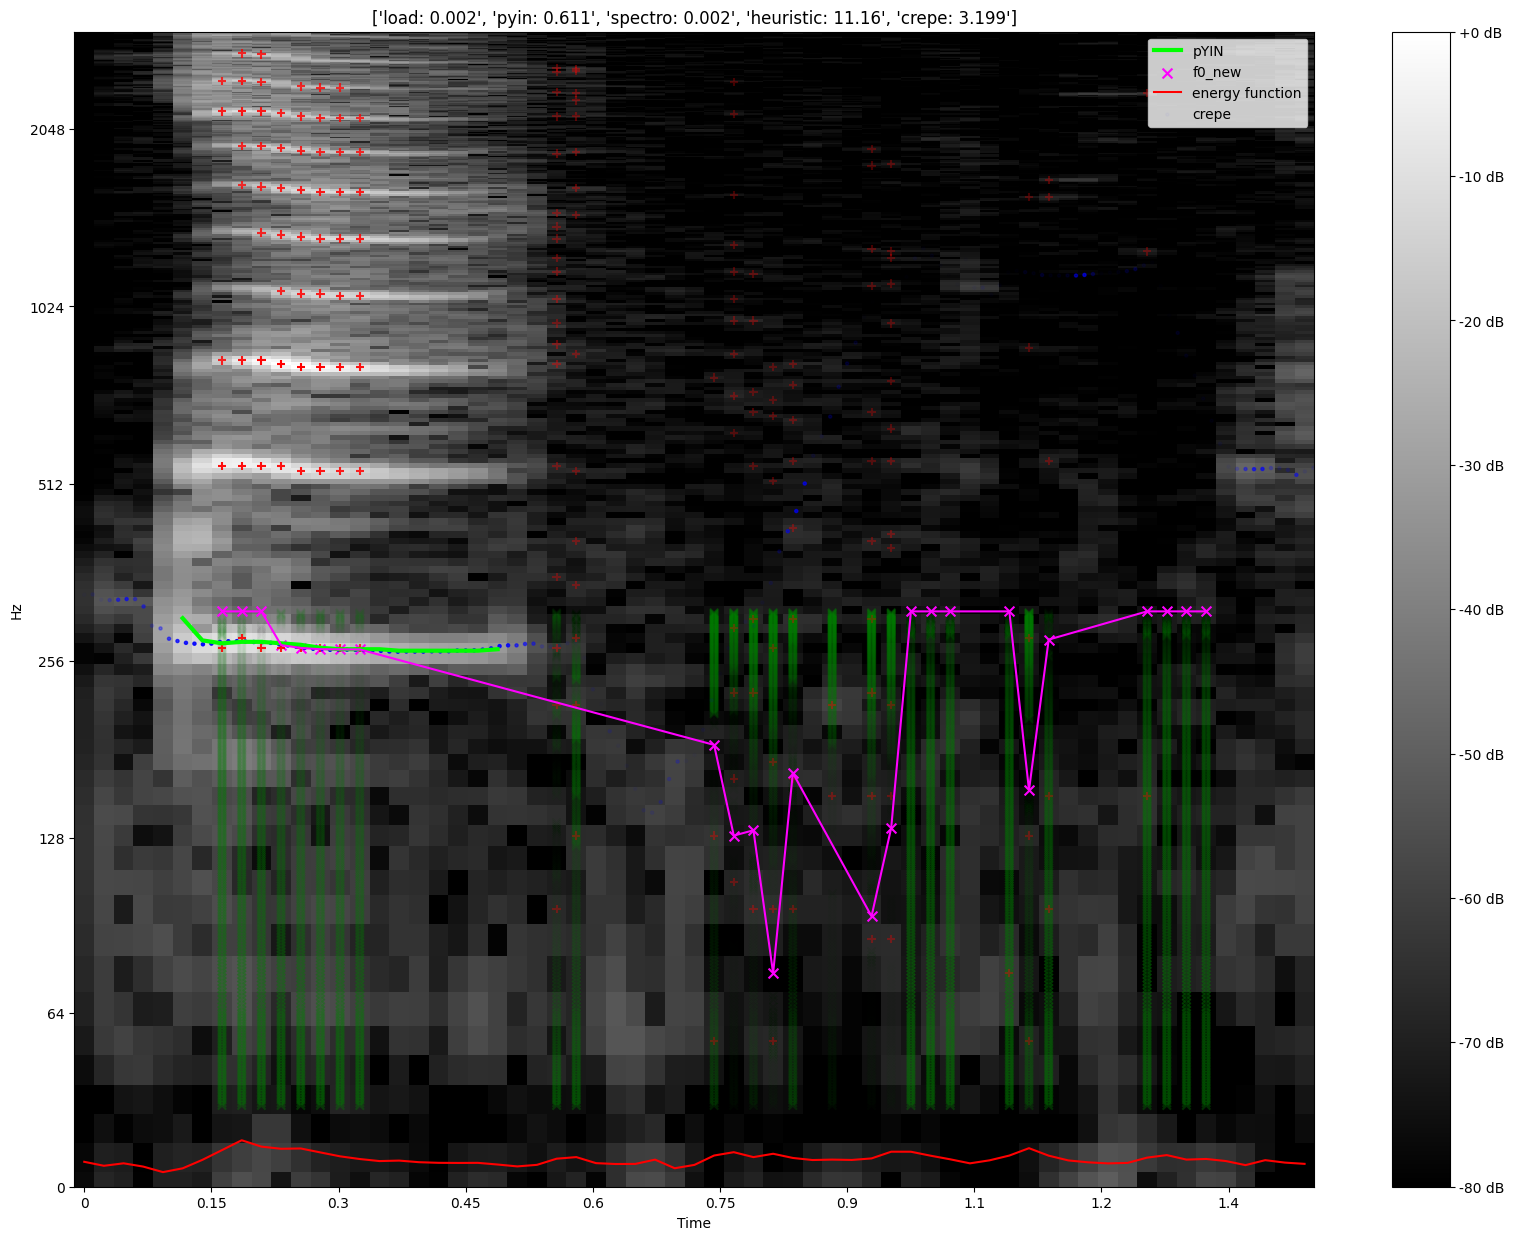

([0.002950906753540039,
  0.6113107204437256,
  0.0029594898223876953,
  11.167449712753296,
  3.199509620666504],
            t      f0          loss
 7   0.162540  310.59  4.533009e+08
 8   0.185760  310.59  9.035225e+07
 9   0.208980  310.59  5.907709e+06
 10  0.232200  272.22  2.278994e+04
 11  0.255420  269.17  9.392673e-01
 12  0.278639  267.84  9.928396e+03
 13  0.301859  267.70  9.542452e+03
 14  0.325079  267.59  8.599394e+03
 32  0.743039  184.21  4.352976e+07
 33  0.766259  129.19  2.609267e+07
 34  0.789478  131.89  8.487698e+06
 35  0.812698   75.36  5.382359e+07
 36  0.835918  165.08  1.942852e+09
 40  0.928798   94.20  3.930146e+08
 41  0.952018  133.24  1.567918e+07
 42  0.975238  310.59  6.495362e+10
 43  0.998458  310.59  6.190364e+10
 44  1.021678  310.59  5.905080e+10
 47  1.091338  310.59  9.190097e+09
 48  1.114558  154.32  2.589556e+08
 49  1.137778  278.13  1.726362e+09
 54  1.253878  310.59  6.743117e+09
 55  1.277098  310.59  2.386780e+10
 56  1.300317  310.59

In [37]:
def visualise_frequencies(audio_path, out_path, show_fig = False):
    spectrogram, sr, times, f0, valid_frames, energy_function, estimated_times, load_times, allowed_freq_ranges, all_peaks,freq_list,test_peaks_cleaned_list, display_output_loss_list, crepe_values = process_audio(audio_path, energy_threshold = 10)
    
    # clean sequence - must have at least 3 in a row, otherwise remove
    frame_list = valid_frames.index
    remove_frames = np.zeros(len(frame_list))
    back_1_frame = -10
    back_2_frames = -10
    for frame_index in range(len(frame_list)):
        frame_value = frame_list[frame_index]
        if (back_2_frames == back_1_frame - 1) and (back_1_frame == frame_value - 1):
            for index in range(frame_index-2,frame_index+1):
                remove_frames[index] = 1
        back_2_frames = back_1_frame
        back_1_frame = frame_value
    valid_frames = valid_frames.loc[remove_frames==1]
    
    # visualise
    fig, ax = plt.subplots(figsize=[20,15])
    img = librosa.display.specshow(spectrogram, x_axis='time', ax=ax, sr=sr, y_axis='log', cmap = 'gray')
    ax.set(title=str([a+": "+str(b)[:5] for a,b in zip(['load','pyin','spectro','heuristic','crepe'],load_times)]))
    fig.colorbar(img, ax=ax, format="%+2.f dB")

    freq_range_coordinates = []
    freq_range_noncoordinates = []
    freq_range_times = []
    freq_range_nontimes = []
    """
    for freq_ranges, time_frame in zip(allowed_freq_ranges, estimated_times):
        if freq_ranges!= None:
            for freq_range in freq_ranges:
                for freq in freq_range:
                    if freq < 3000:
                        freq_range_coordinates.append(freq)
                        freq_range_times.append(time_frame)
    ax.scatter(freq_range_times,freq_range_coordinates,color='red',marker='_')
    """
    for peak_flags, time_frame in zip(all_peaks, estimated_times):
        if peak_flags!= None:
            for peak_flag_index in range(len(peak_flags)):
                if peak_flags[peak_flag_index]!=1:
                    freq = freq_list[peak_flag_index]
                    if freq < 3000:
                        freq_range_coordinates.append(freq)
                        freq_range_times.append(time_frame)

    #ax.scatter(freq_range_times,freq_range_coordinates,color='green',marker='x', alpha=0.7)

    loss_scatter_t = []
    loss_scatter_f = []
    loss_scatter_a = []
    #print('display_output_loss_list', display_output_loss_list)
    for losses_list, time_frame in zip(display_output_loss_list, estimated_times):
        if losses_list!= None:
            loss_scatter_a_temp = []
            #print('rendering',time_frame)
            for frequency,loss_value in zip(losses_list[0],losses_list[1]):
                if round(frequency, 0) == round(frequency,1):
                    loss_scatter_t.append(time_frame)
                    loss_scatter_f.append(frequency)
                    loss_scatter_a_temp.append(loss_value)
            loss_scatter_a_temp = [(x-min(loss_scatter_a_temp))/(max(loss_scatter_a_temp)-min(loss_scatter_a_temp)) for x in loss_scatter_a_temp]
            for a in loss_scatter_a_temp:
                loss_scatter_a.append(a)
    #print(pd.DataFrame([loss_scatter_t,loss_scatter_f,loss_scatter_a], index=['t','f','a']).transpose())
    ax.scatter(loss_scatter_t,loss_scatter_f,color='green',marker='x', alpha=0.5*np.log([1+a for a in loss_scatter_a]))


    # draw lines
    ax.plot(times, f0, label='pYIN', color='lime', linewidth=3)
    ax.scatter(valid_frames['t'], valid_frames['f0'], label='f0_new', color='fuchsia', marker = 'x', s = 50)#, alpha = [1-x/max(valid_frames['loss']) for x in valid_frames['loss']], s = [10*(1-x/max(valid_frames['loss'])) for x in valid_frames['loss']])
    ax.plot(valid_frames['t'], valid_frames['f0'], color='fuchsia')#, alpha = [1-x/max(valid_frames['loss']) for x in valid_frames['loss']], s = [10*(1-x/max(valid_frames['loss'])) for x in valid_frames['loss']])
    #for timestamp, coordinate in zip(valid_frames['t'], valid_frames['f0']):
    #    ax.text(x = timestamp, y = coordinate*1.2, s = str(timestamp)[:5]+', '+str(coordinate)[:4], rotation = 90, ha = 'center', va = 'bottom', color = 'white')
    ax.plot(estimated_times, energy_function, label='energy function', color='red')
    #crepe_values = [crepe_time, crepe_frequency, crepe_confidence]
    ax.scatter(crepe_values[0], crepe_values[1], label='crepe', color = 'blue', alpha = crepe_values[2], s=5)    
    

    peak_coordinates = []
    peak_times = []
    peak_heights = []
    for cleaned_peaks, time_frame in zip(test_peaks_cleaned_list, estimated_times):
        if cleaned_peaks!= None:
            for peak_value in cleaned_peaks:
                if peak_value[1] < 3000:
                    peak_coordinates.append(peak_value[1])
                    peak_heights.append(min(1,(100+peak_value[0])/100))
                    peak_times.append(time_frame)
    
    ax.scatter(peak_times,peak_coordinates,color='red',marker='+', alpha=peak_heights)

    #ax.plot(estimated_times, [500*x for x in energy_concentration], label='energy_spread', color='pink')
    ax.legend(loc='upper right')
    ax.set_ylim([0,3000])
    plt.savefig(out_path)
    #if show_fig:
    plt.show()
    return load_times, valid_frames

visualise_frequencies(audio_path, "./outputs", show_fig=True)

And then now we run these functions on the dataset

In [32]:
import glob

all_times = []
out_path_base = './outputs'
# folders = glob.glob('./data/Chinese DPA/audio/*')
folders = glob.glob("./data/Chiense DPA/Chinese DPA/audio/c86b0c/*")
for folder in folders:
    audio_paths = glob.glob(folder+'/*.wav')
    for audio_path in audio_paths:
        sample_name = audio_path.split('\\')[-1].split('.')[0]
        out_path = out_path_base+'/'+sample_name+'.png'
        load_times, valid_frames = visualise_frequencies(audio_path, out_path, show_fig=False)
        all_times.append([audio_path, load_times])
    with open('all_timings.txt','w') as f:
        f.write(str(all_times))
    break
print(all_times)

[]
